In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost.sklearn import XGBRegressor
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
test=pd.read_csv('/content/drive/MyDrive/data/test_modified.csv')
train=pd.read_csv('/content/drive/MyDrive/data/train_modified.csv')

## Splitting the data

In [ ]:
# Split the train data into features (X) and target variable (y)
X = train.drop(columns=['price'])
y = train['price']

# Split the train data into train and test sets for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. XGBoost Regressor

In [2]:
# Initialize the XGBoost Regressor
xgbr = XGBRegressor(n_estimators=500, max_depth=10, subsample=0.5)

# Train the model
start = time.time()
xgbr.fit(X_train, y_train)
training_duration = time.time() - start
print('Training Duration in minutes: ', round(training_duration / 60, 2))

# Make predictions on the test set and training set
y_pred_xgbr = xgbr.predict(X_test)
y_pred_xgbr_train = xgbr.predict(X_train)

# Evaluate the model
print('XGB Regressor Train MAE: ', round(mean_absolute_error(y_train, y_pred_xgbr_train), 2))
print('XGB Regressor Test MAE: ', round(mean_absolute_error(y_test, y_pred_xgbr), 2))
print('XGB Regressor Train RMSE: ', round(np.sqrt(mean_squared_error(y_train, y_pred_xgbr_train)), 2))
print('XGB Regressor Test RMSE: ', round(np.sqrt(mean_squared_error(y_test, y_pred_xgbr)), 2))
print('XGB Regressor Train R2: ', round(xgbr.score(X_train, y_train), 4)*100)
print('XGB Regressor Test R2: ', round(r2_score(y_test, y_pred_xgbr), 4)*100)

# Visualize the model fit
plt.figure(figsize=(10,6))
plt.title('XGBoost Regressor Model Fit', fontsize=14)
plt.scatter(x=y_test, y=y_pred_xgbr)
m, b = np.polyfit(y_test, y_pred_xgbr, 1)
plt.plot(y_test, m*y_test+b, 'r')
plt.show()


In [ ]:
# Prepare Kaggle's test data
X_test_kaggle = test

# Make predictions on Kaggle's test data
y_pred_kaggle = xgbr.predict(X_test_kaggle)

# Create a DataFrame with 'id' and predicted 'price'
submission_df = pd.DataFrame({'id': X_test_kaggle['id'], 'price': y_pred_kaggle})

# Save the submission DataFrame to a CSV file
file_path = 'submission_xgbr.csv'
submission_df.to_csv(file_path, index=False)

# Optionally, you can print the first few rows of the DataFrame to verify the content
print(submission_df.head())

from google.colab import files
files.download(file_path)

           id         price
0  7313399730   2491.912598
1  7308035814  25524.611328
2  7317063645   2154.993164
3  7310376764  36742.789062
4  7309848062  20734.654297


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Hyperparameter tuning

In [ ]:
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

The baseline XGBoost regressor was overfitting, we will be focusing on hyperparamters that help reduce it. The hyperparameters to be tried for the XGBoost are:

* n_estimators: the number of trees. I will be trying out different number of trees between 50 and 1000.
* learning_rate: the boosting learning rate. Will be trying out different learning rates between 0.01 and 1.
* max_depth: maximum tree depth. Will be trying values between 3 and 10.
* min_child_weight: the minimum sum of instance weight needed in a leaf. Larger values should help reduce overfitting. Will be trying out numbers between 0 and 10.
* sub_sample: the ratio of training rows used. Lower values should help reduce overfitting. Will be trying out values between 0 and 1.

Training Duration in minutes:  81.2
Tuned XGBoost Regressor Train MAE:  4877.57
Tuned XGBoost Regressor Test MAE:  5465.33
Tuned XGBoost Regressor Train RMSE:  7985.98
Tuned XGBoost Regressor Test RMSE:  9296.98
Tuned XGBoost Regressor Train R2:  76.41
Tuned XGBoost Regressor Test R2:  63.970000000000006


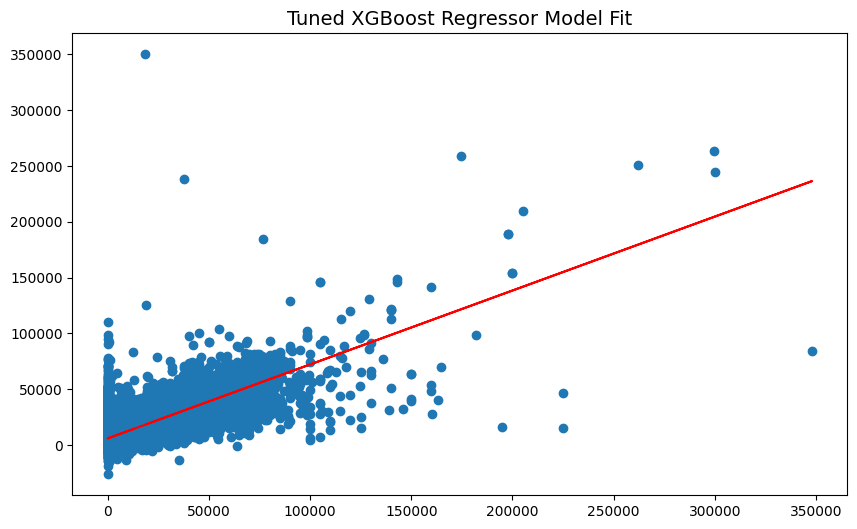

In [ ]:
xgbr_params = {'n_estimators':[50,100,200,500,700,1000],
               'learning_rate':[0.01,0.1,0.2,0.5,0.7,1],
               'max_depth':[3,5,7,10],
               'min_child_weight':[0,1,5,10],
               'subsample':[0,0.2,0.5,0.7,1]}

start = time.time()

xgbr_rscv = RandomizedSearchCV(xgbr, xgbr_params, cv = 3, n_iter=20, n_jobs=-1)
xgbr_rscv.fit(X_train,y_train)

training_duration = time.time() - start
print('Training Duration in minutes: ', round(training_duration / 60, 2))

best_xgbr_model = xgbr_rscv.best_estimator_

y_pred_xgbr_tuned = best_xgbr_model.predict(X_test)
y_pred_xgbr_tuned_train = best_xgbr_model.predict(X_train)

print('Tuned XGBoost Regressor Train MAE: ', round(mean_absolute_error(y_train, y_pred_xgbr_tuned_train), 2))
print('Tuned XGBoost Regressor Test MAE: ', round(mean_absolute_error(y_test, y_pred_xgbr_tuned), 2))
print('Tuned XGBoost Regressor Train RMSE: ', round(np.sqrt(mean_squared_error(y_train, y_pred_xgbr_tuned_train)), 2))
print('Tuned XGBoost Regressor Test RMSE: ', round(np.sqrt(mean_squared_error(y_test, y_pred_xgbr_tuned)), 2))
print('Tuned XGBoost Regressor Train R2: ', round(best_xgbr_model.score(X_train, y_train), 4)*100)
print('Tuned XGBoost Regressor Test R2: ', round(r2_score(y_test, y_pred_xgbr_tuned), 4)*100)

plt.figure(figsize=(10,6))
plt.title('Tuned XGBoost Regressor Model Fit', fontsize=14)
plt.scatter(x=y_test, y=y_pred_xgbr_tuned)
m, b = np.polyfit(y_test, y_pred_xgbr_tuned, 1)
plt.plot(y_test, m*y_test+b, 'r');

We see lower errors in comparison to the baseline XGBoost, but the overfitting has slightly increased.

In [ ]:
best_xgbr_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Prepare Kaggle's test data
X_test_kaggle = test

# Make predictions on Kaggle's test data
y_pred_kaggle = xgbr_rscv.predict(X_test_kaggle)

# Create a DataFrame with 'id' and predicted 'price'
submission_df = pd.DataFrame({'id': X_test_kaggle['id'], 'price': y_pred_kaggle})

# Save the submission DataFrame to a CSV file
file_path = 'submission_xgbr_rscv.csv'
submission_df.to_csv(file_path, index=False)

# Optionally, you can print the first few rows of the DataFrame to verify the content
print(submission_df.head())

from google.colab import files
files.download(file_path)

           id         price
0  7313399730   9603.650391
1  7308035814  27816.142578
2  7317063645   5761.097656
3  7310376764  32787.703125
4  7309848062  23516.087891


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>